In [1]:
library(devtools)
# library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
# library(quantmod)
# library(xts)
# library(zoo)
library(gridExtra)
# library(tibble)
library(grid)
# library(future)
# library(future.apply)
# library(DescTools)
# library(rcompanion)
# library(tidyverse)
library(parallel)

source("forecast_research/finance/markets_functions.R")
load_all("forecast_research/vendor/hmmTMB")
remotes::install_local("/project/6004619/dcs01/forecast_research/vendor/hmmTMB")
options(warn = -1)

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: TMB

Skipping install of 'hmmTMB' from a local remote, the SHA1 (1.1.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
source("forecast_research/finance/markets_functions.R")

## Import close data

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_Care_Index, Shipping_Futures



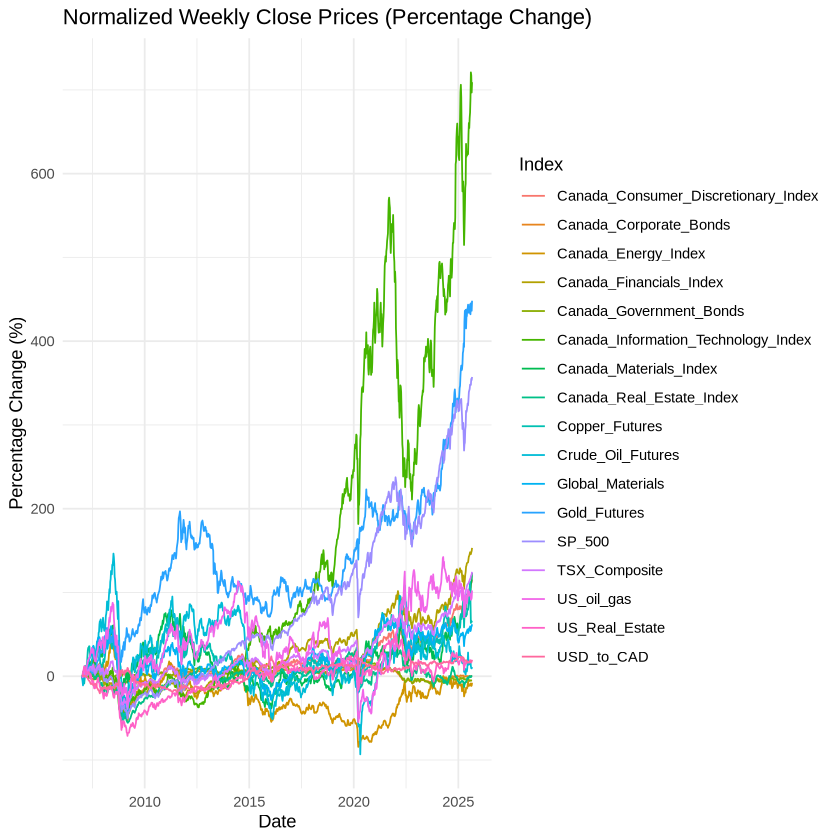

In [3]:
close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures,
    USD_to_CAD, Canada_Corporate_Bonds,
    Canada_Government_Bonds, US_oil_gas, Global_Materials,
    US_Real_Estate, SP_500,
  )

close_data_log <- ln_transform(close_data)

In [9]:
library(R6)

HMMForecaster <- R6Class(
  "HMMForecaster",
  public = list(
    data = NULL,
    train_size = NULL,
    test_size = NULL,
    buffer_size = NULL,
    n_samples = NULL,
    n_states = NULL,
    obs_name = NULL,
    cov_name = NULL,
    eval_range = NULL,
    samples = NULL,
    ncores = NULL,

    hmms = NULL,
    hmm_forecasts = NULL,
    full_hmms = NULL,
    train_states = NULL,
    test_state_probs = NULL,
    cov_data = NULL,
    cov_formula = NULL,
    lag_hmms = NULL,
    cov_forecasts = NULL,
    hmm_evaluations = NULL,
    cov_hmm_evaluations = NULL,
    cov_models = NULL,

    initialize = function(
      data,
      train_size,
      test_size = 2,
      buffer_size = 5,
      n_samples = 2,
      n_states = 3,
      obs_name = "TSX_Composite",
      cov_name = "Gold_Futures",
      eval_range = setNames(list(seq(from = -0.2, to = 0.2, by = 0.001)), obs_name)
    ) {
      self$data <- data
      self$train_size <- train_size
      self$test_size <- test_size
      self$buffer_size <- buffer_size
      self$n_samples <- n_samples
      self$n_states <- n_states
      self$obs_name <- obs_name
      self$cov_name <- cov_name
      self$eval_range <- eval_range
      self$samples <- private$init_samples()
      self$ncores <- as.integer(Sys.getenv("SLURM_CPUS_PER_TASK", "1"))
    },

    run = function() {
      # Step 1: For each sample, fit HMM
      self$hmms <- private$fit_hmm_to_samples(
        self$samples,
        self$n_states,
        self$obs_name
      )

      # Step 2: For each hmm, perform forecast
      self$hmm_forecasts <- private$forecast_hmms(
        self$hmms,
        self$samples
      )

      # Step 3: for each sample get ground truth states
      private$compute_states_from_hmm(
        self$hmms,
        self$samples
      )

      # Step 4: for each sample construct coavariate hidden states
      self$cov_data <- private$compute_cov_data(
        self$samples
      )
      self$cov_formula <- private$compute_cov_formula()

      # Step 5: Compute lagged HMMs with covariates for each sample
      self$lag_hmms <- lapply(1:self$test_size, function(lag) {
        private$fit_cov_hmm(lag)
      })

      # Step 6: Forecast with lagged HMMs
      self$cov_forecasts <- lapply(1:self$test_size, function(lag) {
        private$forecast_cov_hmms(lag)
      })

      # Step 7: Evaluate hmm forecasts
      self$hmm_evaluations <- private$evaluate_forecasts(self$hmm_forecasts, self$test_size)

      self$cov_hmm_evaluations <- lapply(1:self$test_size, function(lag) {
        private$evaluate_forecasts(self$cov_forecasts[[lag]], lag)
      })
    },

    get_samples = function() {
      self$samples
    },

    get_hmms = function() {
      self$hmms
    },

    get_cov_data = function() {
      self$cov_data
    },

    get_cov_formula = function() {
      self$cov_formula
    }

  ),
  private = list(
    init_samples = function() {
      nrows <- nrow(self$data)
      split_index <- as.integer(seq(
        from = self$train_size,
        to = nrows - self$test_size - self$buffer_size,
        length.out = self$n_samples
      ))
      samples <- lapply(split_index, function(idx) {
        train <- self$data[(idx - self$train_size + 1):idx, ]
        test <- self$data[(idx + 1):(idx + self$test_size), ]
        buffer <- self$data[(idx + self$test_size + 1):(idx + self$test_size + self$buffer_size), ]
        list(
          train = train,
          test = test,
          buffer = buffer
        )
      })
      samples
    },

    fit_hmm_to_samples = function(samples, n_states, obs_name) {
      mclapply(samples, function(sample) {
        train_data <- sample$train
        hid_model <- MarkovChain$new(
          data = train_data,
          n_states = n_states,
          formula = ~1,
          initial_state = "estimated"
        )
        obs_model <- Observation$new(
          data = train_data,
          n_states = n_states,
          dists = setNames(list("norm"), obs_name),
          par = setNames(
            list(
              list(
                mean = seq(-0.02, 0.01, length.out = n_states),
                sd = seq(0.1, 0.01, length.out = n_states)
              )
            ),
            obs_name
          )
        )

        hmm <- HMM$new(hid = hid_model, obs = obs_model)
        hmm$fit(silent = TRUE)
        hmm
      }, mc.cores = self$ncores, mc.set.seed = TRUE)
    },

    forecast_hmms = function(hmms, samples) {
      mapply(function(hmm, sample) {
        Forecast$new(
          hmm                        = hmm,
          forecast_data              = sample$test,
          starting_state_distribution = "last",
          preset_eval_range          = self$eval_range
        )
      }, hmms, samples, SIMPLIFY = FALSE)
    },

    compute_states_from_hmm = function(hmms, samples) {
      self$train_states <- list()
      self$test_state_probs <- list()
      self$full_hmms <- list()
      invisible(mapply(function(hmm, sample) {
        full_data <- rbind(sample$train, sample$test, sample$buffer)
        hid_model <- MarkovChain$new(
          data = full_data,
          n_states = self$n_states,
          formula = ~1,
          initial_state = "estimated"
        )
        obs_model <- Observation$new(
          data = full_data,
          n_states = self$n_states,
          dists = setNames(list("norm"), self$obs_name),
          par = setNames(
            list(
              list(
                mean = seq(-0.02, 0.01, length.out = self$n_states),
                sd = seq(0.1, 0.01, length.out = self$n_states)
              )
            ),
            self$obs_name
          )
        )
        full_hmm <- HMM$new(init = hmm, hid = hid_model, obs = obs_model)
        self$full_hmms <- c(self$full_hmms, list(full_hmm))
        
        states_vector <- unlist(full_hmm$states()[0:self$train_size])
        self$train_states <- c(self$train_states, list(states_vector))

        state_probs_matrix <- full_hmm$state_probs()[(self$train_size + 1):(self$train_size + self$test_size), ]
        self$test_state_probs <- c(self$test_state_probs, list(state_probs_matrix))
      }, hmms, samples, SIMPLIFY = FALSE))
    },

    compute_cov_data = function(samples) {
      # To be implemented
      if (length(self$cov_name) == 1) {
        cov_hmm_list <- private$fit_hmm_to_samples(samples, self$n_states, self$cov_name)
        self$cov_models <- cov_hmm_list
        
        lapply(cov_hmm_list, function(hmm) {
          cov_states <- hmm$state_probs()
          colnames(cov_states) <- paste0(self$cov_name, "_State_", seq_len(self$n_states))
          cov_states
        })
      } else if (length(self$cov_name) > 1) {
        cov_hmm_list <- lapply(self$cov_name, function(cov_n) {
          private$fit_hmm_to_samples(samples, self$n_states, cov_n)
        })
        self$cov_models <- cov_hmm_list
        
        lapply(1:length(samples), function(i) {
          cov_states_list <- lapply(1:length(self$cov_name), function(j) {
            hmm <- cov_hmm_list[[j]][[i]]
            cov_states <- hmm$state_probs()
            colnames(cov_states) <- paste0(self$cov_name[j], "_State_", seq_len(self$n_states))
            cov_states
          })
          do.call(cbind, cov_states_list)
        })
      } else {
        stop("cov_name must be a character string or a vector of character strings.")
      }
    },

    compute_cov_formula = function() {
      if (length(self$cov_name) > 1) {
        formula_parts <- unlist(lapply(self$cov_name, function(cov_n) {
          paste0(cov_n, "_State_", seq_len(self$n_states))
        }))
      } else {
        formula_parts <- paste0(self$cov_name, "_State_", seq_len(self$n_states))
      }
      formula_str <- paste(formula_parts, collapse = " + ")
      as.formula(paste("~ 1 +", formula_str))
    },

    split_cov_data = function(cov_data, sample, train_state, lag) {
      lagged_cov <- rbind(
        matrix(NA, nrow = lag, ncol = self$n_states*length(self$cov_name)),
        cov_data
      )
      # Create full combined data
      train_data <- data.frame(
        obs = sample$train[[self$obs_name]],
        state = train_state,
        lagged_cov[1:self$train_size, , drop = FALSE],
        check.names = FALSE
      )
      names(train_data)[1] <- self$obs_name
      test_data <- data.frame(
        lagged_cov[(self$train_size + 1):(self$train_size + lag), , drop = FALSE],
        check.names = FALSE
      )
      # Always cut the first n rows so that all lags have the same test size.
      train_data <- train_data[(self$test_size + 1):self$train_size, ]
      list(train_data = train_data, test_data = test_data)
    },

    fit_cov_hmm = function(lag) {
      mcmapply(function(cov_data, sample, hmm, state) {
        cov_split <- private$split_cov_data(cov_data, sample, state, lag)
        train_data <- cov_split$train_data
        
        # Create semi supervised hidden model using covariates and known states
        hid_model <- MarkovChain$new(
          data = train_data,
          n_states = self$n_states,
          formula = self$cov_formula,
          initial_state = "estimated"
        )
        # Initialize observation model using previous hmm parameters
        par0 <- setNames(
          list(
            list(
              mean = hmm$par()$obspar[seq(1, length(hmm$par()$obspar), by = 2)],
              sd = hmm$par()$obspar[seq(2, length(hmm$par()$obspar), by = 2)]
            )
          ),
          self$obs_name
        )
        obs_model <- Observation$new(
          data = train_data,
          n_states = self$n_states,
          dists = setNames(list("norm"), self$obs_name),
          par = par0
        )
        obs_names <- rownames(hmm$obs()$coeff_fe())
        fixpar <- list(obs = setNames(rep(NA, length(obs_names)), obs_names))

        cov_hmm <- HMM$new(hid = hid_model, obs = obs_model, fixpar = fixpar)
        cov_hmm$fit(silent = TRUE)
        cov_hmm
      }, self$cov_data, self$samples, self$hmms, self$train_states, SIMPLIFY = FALSE,
      mc.cores = self$ncores, mc.set.seed = TRUE)
      
    },

    forecast_cov_hmms = function(lag) {
      mapply(function(cov_hmm, sample, cov_data) {
        cov_split <- private$split_cov_data(cov_data, sample, rep(0, times = nrow(sample$train)), lag)
        test_data <- cov_split$test_data
        Forecast$new(
          hmm                        = cov_hmm,
          forecast_data              = test_data,
          starting_state_distribution = "last",
          preset_eval_range          = self$eval_range
        )
      }, self$lag_hmms[[lag]], self$samples, self$cov_data, SIMPLIFY = FALSE)
    },

    evaluate_forecasts = function(hmm_forecasts, test_size) {
      sample_cross_entropy <- mapply(function(forecast, true_states) {
        forecast_states <- matrix(
          forecast$hidden_state_forecast(),
          ncol = n_states,
          byrow = TRUE
        )
        true_states <- true_states[(1:test_size), , drop = FALSE]
        state_cross_entropy <- as.matrix(
          -rowSums(true_states * log(forecast_states + 1e-10))
          , nrow = test_size, ncol = -1
        )
      }, hmm_forecasts, self$test_state_probs, SIMPLIFY = FALSE)
      ce_matrix <- do.call(cbind, sample_cross_entropy)
      colnames(ce_matrix) <- paste0("Sample_", seq_len(ncol(ce_matrix)))
      means <- rowMeans(ce_matrix, na.rm = TRUE)
      medians <- apply(ce_matrix, 1, median, na.rm = TRUE)
      percentile_25 <- apply(ce_matrix, 1, function(x) quantile(x, 0.25, na.rm = TRUE))
      percentile_75 <- apply(ce_matrix, 1, function(x) quantile(x, 0.75, na.rm = TRUE))
      list(
        mean = means,
        median = medians,
        percentile_25 = percentile_25,
        percentile_75 = percentile_75,
        samples = ce_matrix
      )
    }
  ) # Close private list
)

In [20]:
train_cutoff <- as.Date("2020-01-01")
train_size <- which.min(abs(close_data$Date - train_cutoff))
test_size <- 8
buffer_size <- 5
n_samples <- 50
n_states <- 3
obs_name <- "TSX_Composite"
cov_name <- c("Gold_Futures", "Crude_Oil_Futures")
eval_range <- setNames(list(seq(from = -0.2, to = 0.2, by = 0.001)), obs_name)

log_data <- ln_transform(close_data)

forecaster <- HMMForecaster$new(
  data = log_data,
  train_size = train_size,
  test_size = test_size,
  buffer_size = buffer_size,
  n_samples = n_samples,
  n_states = n_states,
  obs_name = obs_name,
  cov_name = cov_name,
  eval_range = eval_range
)
forecaster$run()

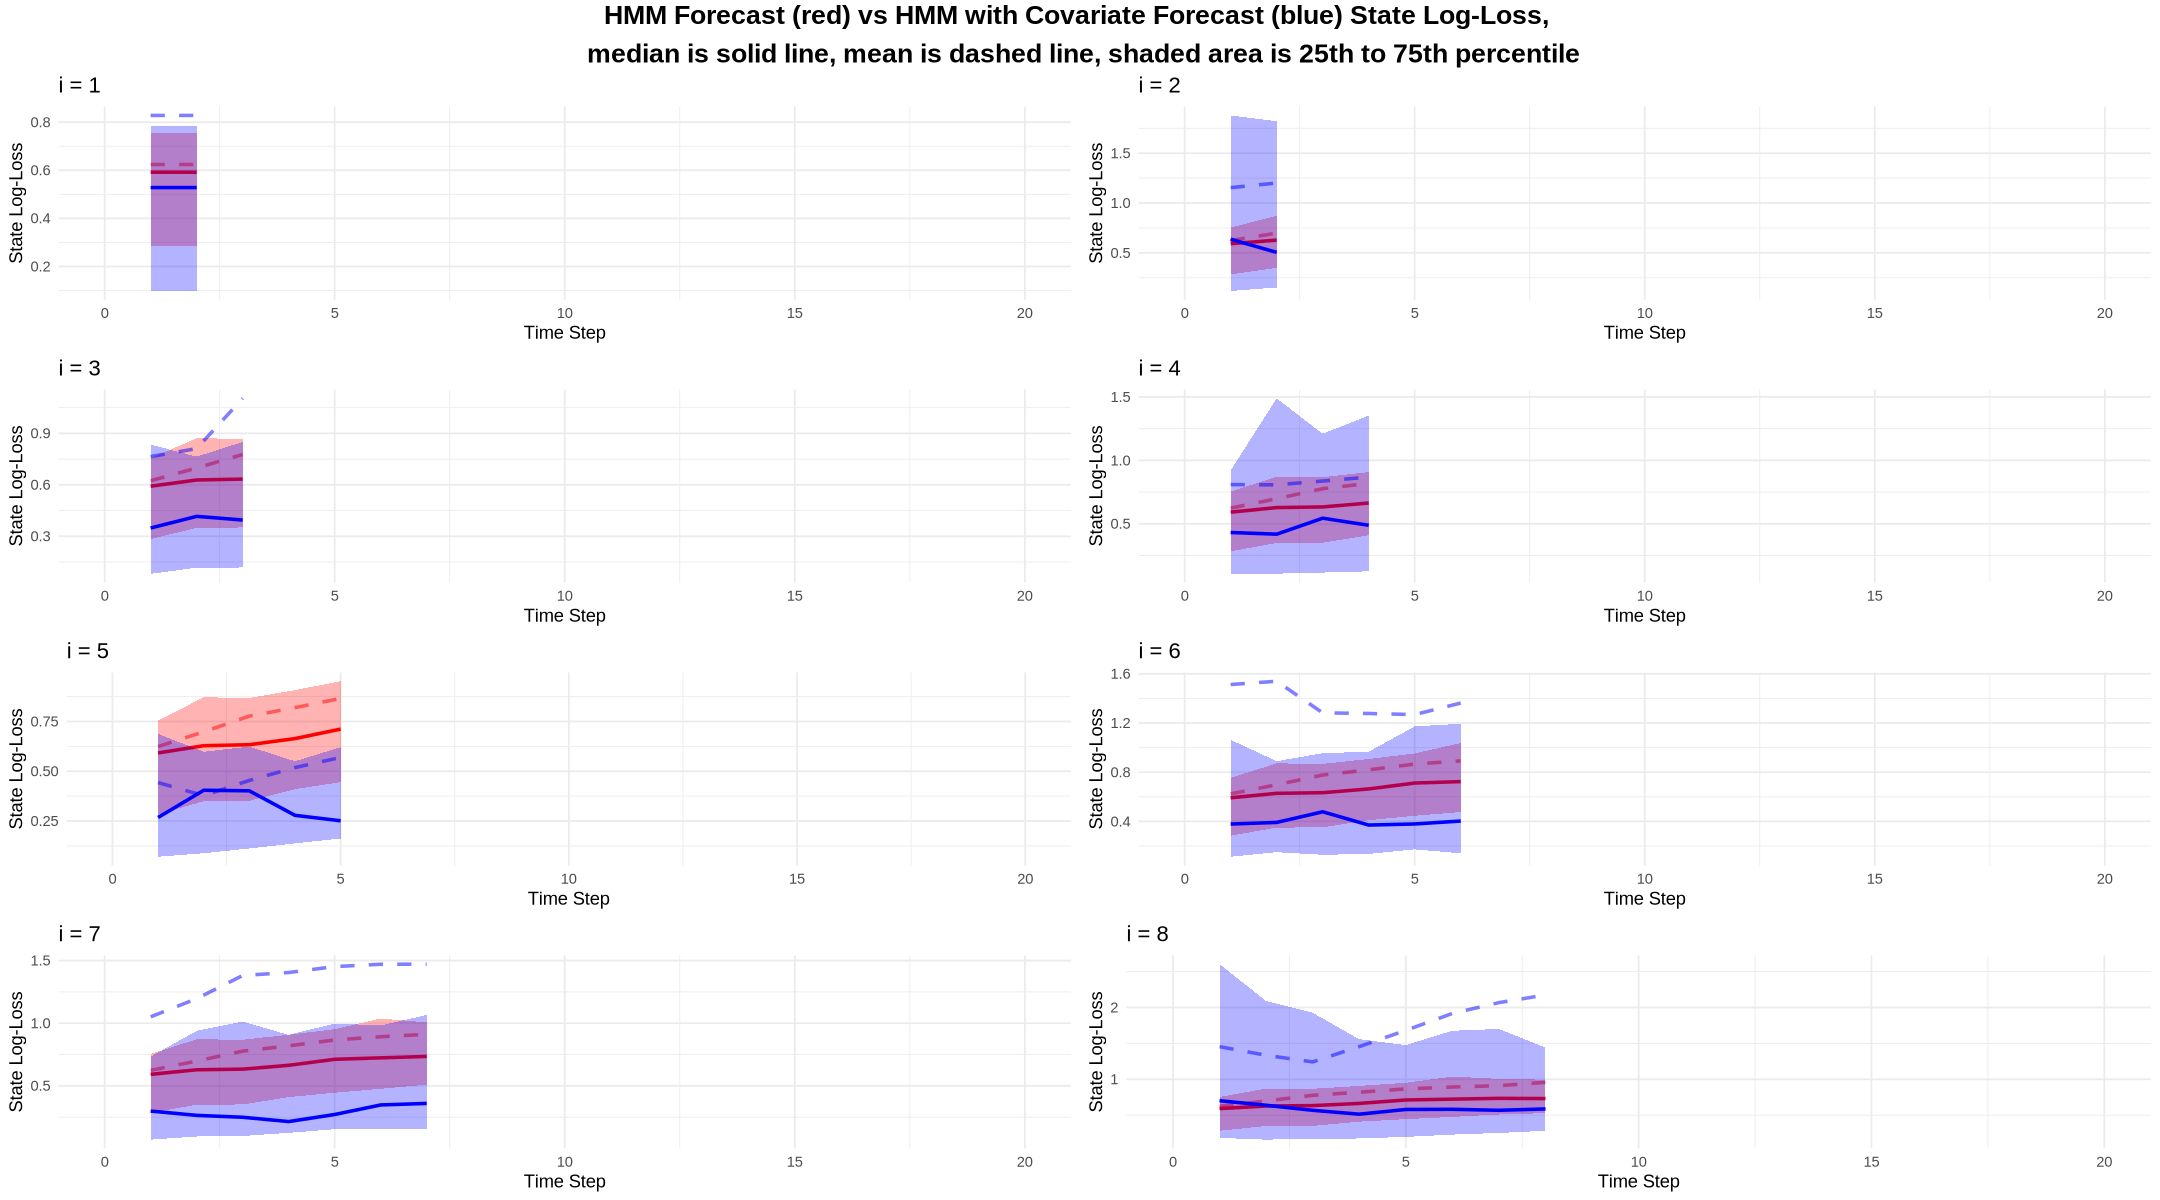

In [21]:
hmm_evals <- forecaster$hmm_evaluations
cov_evals <- forecaster$cov_hmm_evaluations

plot_list <- lapply(1:length(cov_evals), function(i) {
  plot_data <- data.frame(
    x = 1:i,
    median = hmm_evals$median[1:i],
    lower = hmm_evals$percentile_25[1:i],
    upper = hmm_evals$percentile_75[1:i],
    mean = hmm_evals$mean[1:i],
    cov_median = cov_evals[[i]]$median,
    cov_lower = cov_evals[[i]]$percentile_25,
    cov_upper = cov_evals[[i]]$percentile_75,
    cov_mean = cov_evals[[i]]$mean
  )
  if (i == 1) {
    plot_data <- rbind(plot_data, plot_data)
    plot_data$x[2] <- 2
  }

  ggplot(plot_data, aes(x = x)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), fill = "red", alpha = 0.3) +
    geom_line(aes(y = median), color = "red", linewidth = 1) +
    geom_line(aes(y = mean), color = "red", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    geom_ribbon(aes(ymin = cov_lower, ymax = cov_upper), fill = "blue", alpha = 0.3) +
    geom_line(aes(y = cov_median), color = "blue", linewidth = 1) +
    geom_line(aes(y = cov_mean), color = "blue", linetype = "dashed", linewidth = 1, alpha = 0.5) +
    labs(x = "Time Step", y = "State Log-Loss", title = paste("i =", i)) +
    xlim(0, 20) +
    theme_minimal()
})

options(repr.plot.width = 18, repr.plot.height = 10)
grid.arrange(grobs = plot_list, ncol = 2, 
             top = textGrob("HMM Forecast (red) vs HMM with Covariate Forecast (blue) State Log-Loss, \n median is solid line, mean is dashed line, shaded area is 25th to 75th percentile",
                           gp = gpar(fontsize = 16, fontface = "bold")))